# House Price Prediction

### 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

### 데이터셋 불러오기

train data

In [2]:
train = pd.read_csv('data/train.csv')
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


test data

In [3]:
test = pd.read_csv('data/test.csv')

test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


## 데이터 살펴보기

pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.

- ID : 집을 구분하는 번호
- date : 집을 구매한 날짜
- price : 타겟 변수인 집의 가격
- bedrooms : 침실의 수
- bathrooms : 침실당 화장실 개수
- sqft_living : 주거 공간의 평방 피트
- sqft_lot : 부지의 평방 피트
- floors : 집의 층 수
- waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
- view : 집이 얼마나 좋아 보이는지의 정도
- condition : 집의 전반적인 상태
- grade : King County grading 시스템 기준으로 매긴 집의 등급
- sqft_above : 지하실을 제외한 평방 피트
- sqft_basement : 지하실의 평방 피트
- yr_built : 집을 지은 년도
- yr_renovated : 집을 재건축한 년도
- zipcode : 우편번호
- lat : 위도
- long : 경도
- sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
- sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

`price`가 없는 test에는 Nan 값이 들어가게 된다.

In [4]:
data = pd.merge(train, test, how='outer')

print(data.shape)
data.head()

(21503, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


지어진 연도의 최솟값은 1900이다. 이를통해 나중에 건물이 얼마나 되었는지를 알려주는 컬럼을 만들것이다.

In [5]:
data['yr_built'].min()

1900

학습 시 목적함수가 normal distribution(정규분포)을 가지는 것은 학습을 더욱 용이하게 만들어준다.

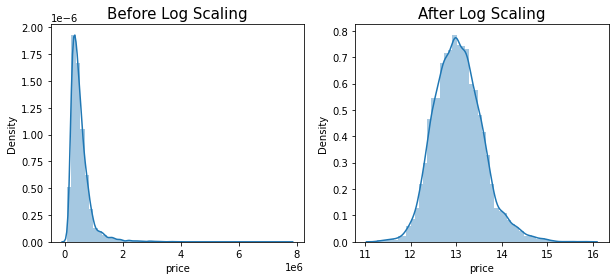

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

sns.distplot(train['price'], ax=axes[0])
axes[0].set_title('Before Log Scaling', fontsize=15)
sns.distplot(np.log1p(train['price']), ax=axes[1])
axes[1].set_title('After Log Scaling', fontsize=15)
plt.show()

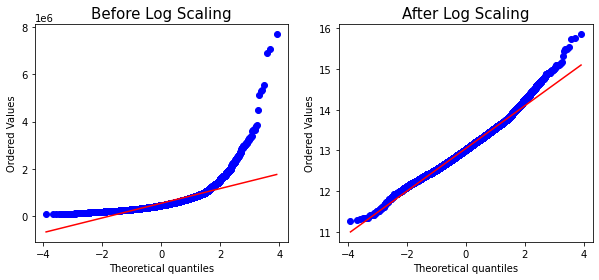

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

reg = stats.probplot(train['price'], plot=axes[0])
axes[0].set_title('Before Log Scaling', fontsize=15)
reg = stats.probplot(np.log1p(train['price']), plot=axes[1])
axes[1].set_title('After Log Scaling', fontsize=15)
plt.show()

### 학습용 데이터 정의

- X_train : 고유값인 `id`와 목적변수 `price`를 제거
- y_train : 목적변수 `price`를 정규분포로 만듬 (추후에 exp 연산을 통해 복구)
- X_test : 고유값인 `id` 제거



In [8]:
X_train = train.drop(['id', 'price'], axis=1)
y_train = train['price']
y_train = np.log1p(y_train)
X_test = test.drop(['id'], axis=1)

### 데이터 전처리

- 데이터는 어짜피 2014년 5월부터 2015년 5월까지의 데이터를 가지고 있으므로 년도의 의미가 크지않다.
- 집을 지은 년도와 재건축 년도는 중요하지만 이것이 중요한 이유는 건축된지 얼마나 되었느냐가 중요한 것이다.
- 이전에 지어진 년도의 최솟값이 1900년도라는 것을 확인했었다. 이 또한 1900년 이후라는 숫자가 중요한 것이 아니라, 지어진지 얼마나 되었느냐가 중요하다
- 지하실을 제외한 평방피트를 층 수로 나누면 층 당 평균 평수가 나온다.

In [9]:
for df in [X_train, X_test]:
    df['date(new)'] = df['date'].apply(lambda x: int(x[4:8])+800 if x[:4] == '2015' else int(x[4:8])-400)
    df['how_old'] = df['date'].apply(lambda x: x[:4]).astype(int) - df[['yr_built', 'yr_renovated']].max(axis=1)
    del df['date']
    del df['yr_renovated']
    df['yr_built'] = df['yr_built'] - 1900
    df['sqft_floor'] = df['sqft_above'] / df['floors']
    df['floor_area_ratio'] = df['sqft_living'] / df['sqft_lot']
    del df['sqft_lot15']

독립변수들의 분포값들을 확인하고 종속변수(price)와 같이 $log1p$ 연산을 통해 정규분포로 변경해준다.

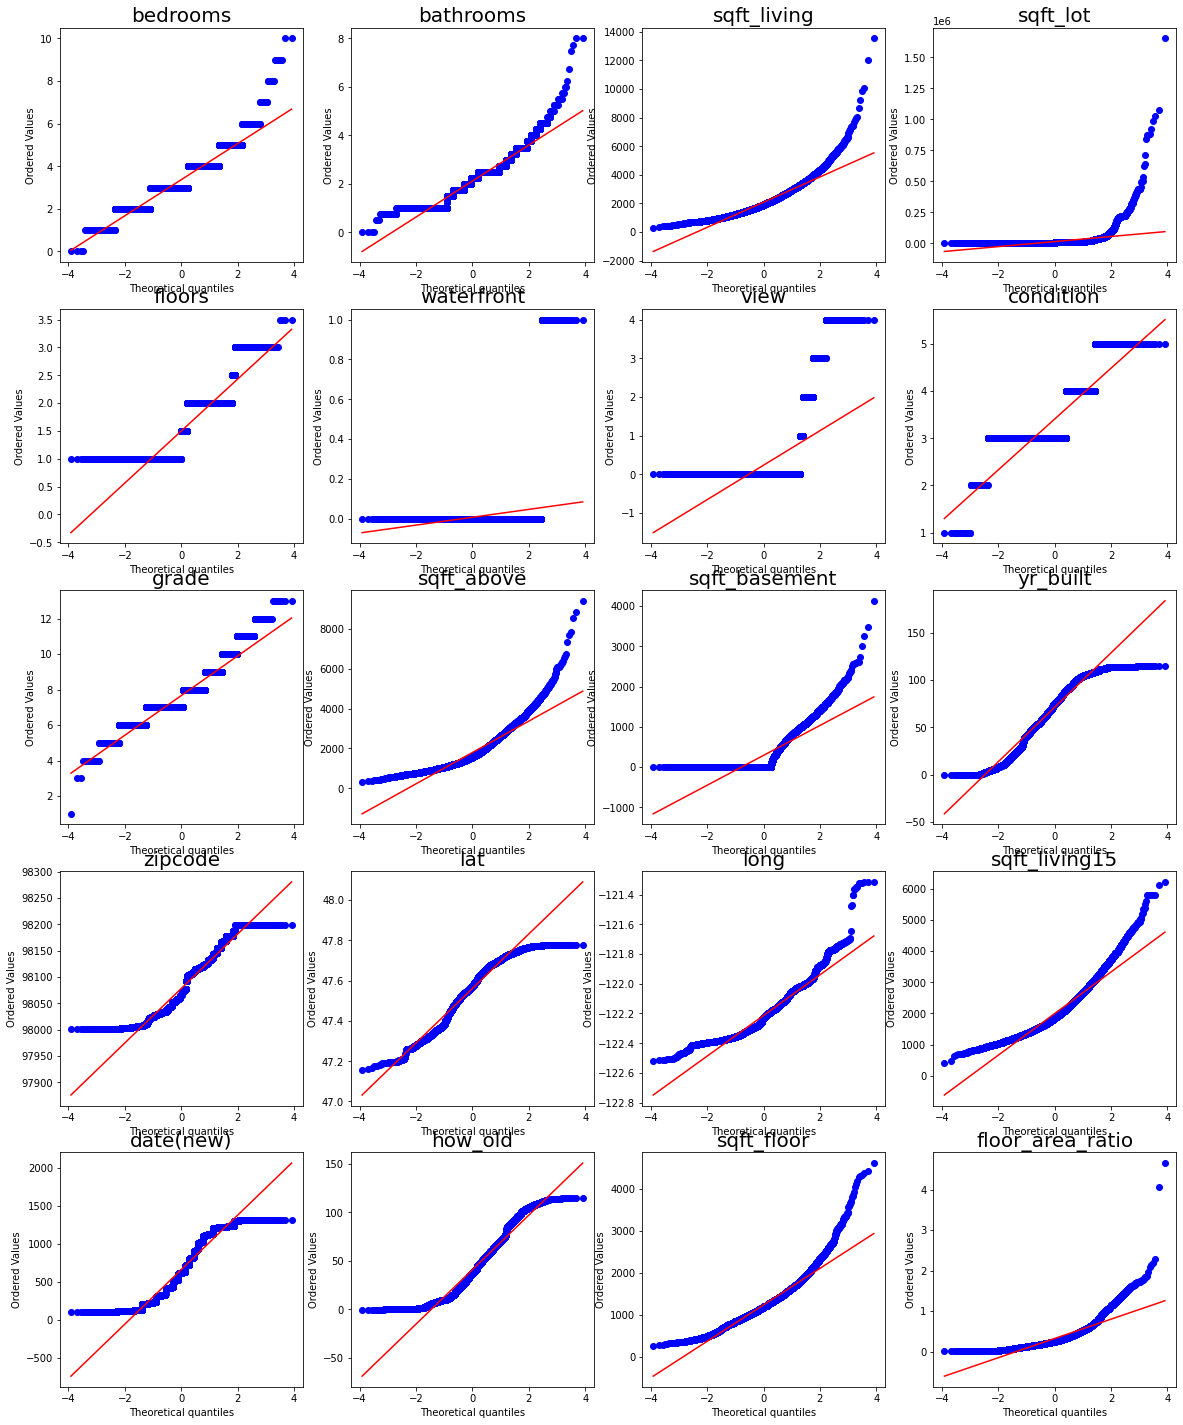

In [10]:
rows = (X_train.shape[1]+3) // 4
fig, axes = plt.subplots(rows, 4, figsize=(20, rows*5))
cols = X_train.columns

for r in range(rows):
    for c in range(4):
        index = 4 * r + c
        if index == len(cols):
            break
        reg = stats.probplot(X_train[cols[index]], plot=axes[r, c])
        axes[r, c].set_title(cols[index], fontsize=20)

In [11]:
log_features = ['bedrooms', 'bathrooms', 'sqft_lot', 'sqft_living', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_floor', 'floor_area_ratio', 'floor_area_ratio']
for feature in log_features:
    for df in [X_train, X_test]:
        df[feature] = np.log1p(df[feature])

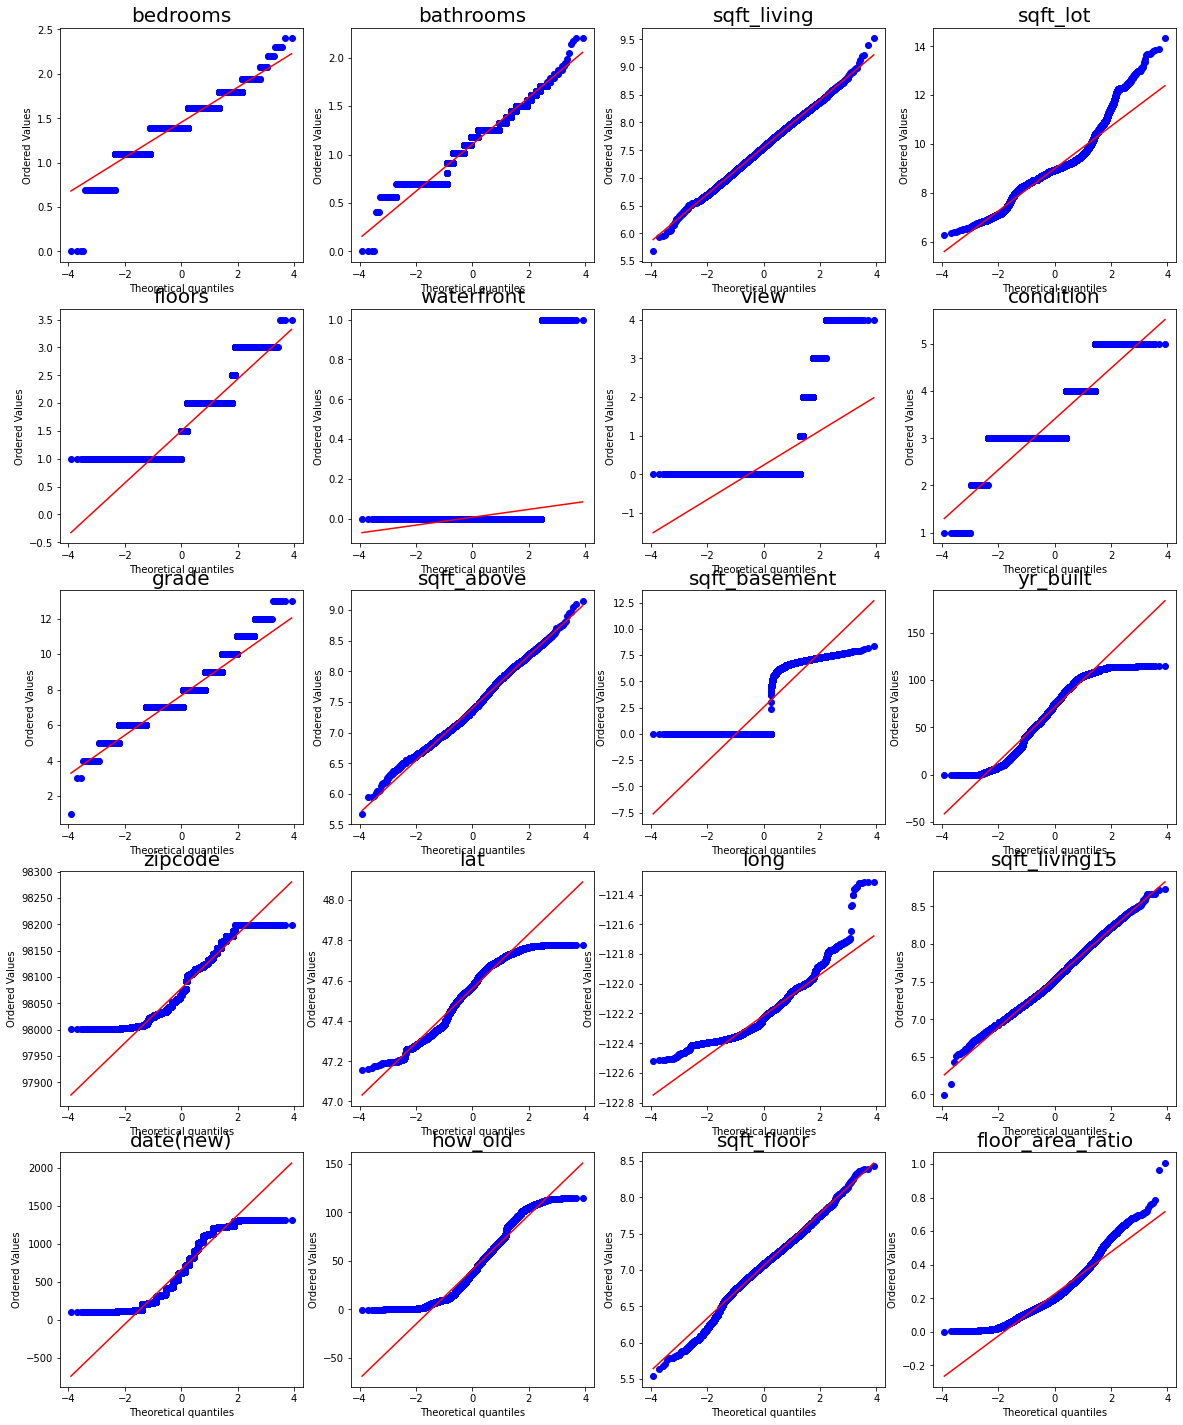

In [12]:
rows = (X_train.shape[1]+3) // 4
fig, axes = plt.subplots(rows, 4, figsize=(20, rows*5))
cols = X_train.columns

for r in range(rows):
    for c in range(4):
        index = 4 * r + c
        if index == len(cols):
            break
        reg = stats.probplot(X_train[cols[index]], plot=axes[r, c])
        axes[r, c].set_title(cols[index], fontsize=20)

## 학습

평가기준은 RMSE

$$
RMSE(y, \bar{y}) = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \bar{y}_i)^2}
$$

In [13]:
def rmse_exp(predictions, dmat):
    labels = dmat.get_label()
    error = np.expm1(predictions) - np.expm1(labels)
    squared_error = np.square(error)
    mean = np.mean(squared_error)
    return ('rmse_exp', np.sqrt(mean))

### 1. 하이퍼 파라미터 튜닝

- 튜닝에는 Grid Search를 이용하였습니다.

In [14]:
xgb_params = {
    'eta': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.4,
    'objective': 'reg:linear',    # 회귀
    'eval_metric': 'rmse',        # kaggle에서 요구하는 검증모델
    'silent': True,               # 학습 동안 메세지 출력할지 말지
    'seed': 4777,
}

### 2. 학습

- 목적변수 Price에 $log1p$를 사용했었기 때문에 그 역함수인 $Exp(x)-1$ 연산을 해줘야 한다.

(6468, 20)
[02:36:50] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[02:36:50] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:36:50] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[02:36:50] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:36:50] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in fav

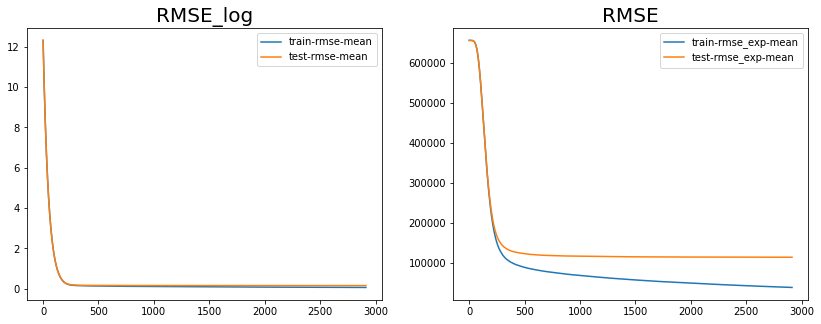

CPU times: user 37min 40s, sys: 11.6 s, total: 37min 52s
Wall time: 3min


In [15]:
%%time

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)
print(X_test.shape)
cv_output = xgb.cv(xgb_params,
                   dtrain,                        
                   num_boost_round=5000,         # the number of boosting trees
                   early_stopping_rounds=100,    # val loss가 계속 상승하면 중지
                   nfold=5,                      # set folds of the closs validation
                   verbose_eval=100,             # 몇 번째마다 메세지를 출력할 것인지
                   feval=rmse_exp,               # price 속성을 log scaling 했기 때문에, 다시 exponential
                   maximize=False,
                   show_stdv=False,              # 학습 동안 std(표준편차) 출력할지 말지
                   )


best_rounds = cv_output.index.size
score = round(cv_output.iloc[-1]['test-rmse_exp-mean'], 2)

print(f'\nBest Rounds: {best_rounds}')
print(f'Best Score: {score}')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot(ax=ax1)
ax1.set_title('RMSE_log', fontsize=20)
cv_output[['train-rmse_exp-mean', 'test-rmse_exp-mean']].plot(ax=ax2)
ax2.set_title('RMSE', fontsize=20)

plt.show()

### 3. 예측

In [16]:
model = xgb.train(xgb_params, dtrain, num_boost_round=best_rounds)
y_pred = model.predict(dtest)
y_pred = np.expm1(y_pred)

[02:39:51] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[02:39:51] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




### 4. 중요도

독립변수들 각각이 모델에 얼마나 많은 영향을 끼쳤는지 보여줌

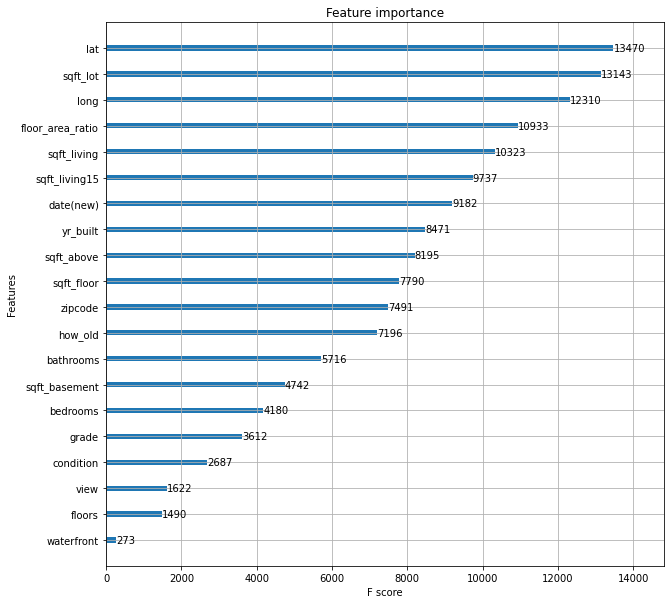

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, ax=ax)

plt.show()

## 제출

In [18]:
sample_submission = pd.read_csv('data/sample_submission.csv')

print(sample_submission.shape)
sample_submission.head()

(6468, 2)


,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [19]:
submission = pd.DataFrame(data = {'id': test['id'], 'price': y_pred.astype(int)})

print(submission.shape)
submission.head()

(6468, 2)


,id,price
0,15035,525459
1,15036,462374
2,15037,1433056
3,15038,302555
4,15039,325701


In [20]:
submission.to_csv('submission.csv', index=False)

![LeaderBoard](leaderboard.png)

public score : 105590.88147